# Real Estate competition - Kaggle
## We will focus on a random forest model, and a few variations
---WORK IN PROGRESS TO BE FINALISED VERY SOON---
### Let's start by importing the necessary modules

In [152]:
import os
import numpy as np
import pandas as pd

import sklearn.linear_model as lm
import sklearn.cross_validation as cv
import sklearn.preprocessing as pp
from  sklearn import metrics, tree, grid_search
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor 

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
os.getcwd()

'/Users/Tavo/Data_science'

### We read the files...

In [4]:
realestate = pd.read_csv('RealEstate/train.csv')
realestate_test = pd.read_csv('RealEstate/test.csv')

data_description = open('RealEstate/data_description.txt', 'r')
print (data_description.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

### Let's examine the columns and get rid of colums (1) with all null values (2) too few values

In [5]:
realestate.info()
realestate_test.info()

realestate = realestate.dropna(how='all')
realestate_test = realestate_test.dropna(how='all')


#columns withe very few values
few_values = ['Alley', 'PoolQC', 'MiscFeature']
realestate = realestate.drop(few_values, axis=1)
realestate_test = realestate_test.drop(few_values, axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [6]:
print(realestate.info())
print(realestate_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 78 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non

### Let's change the data types of some of the columns too

In [7]:
#some columns with categorical variables are not 'object'
realestate.MSSubClass.astype('object', inplace=True)
realestate_test.MSSubClass.astype('object', inplace=True)

0        20
1        20
2        60
3        60
4       120
5        60
6        20
7        60
8        20
9        20
10      120
11      160
12      160
13      160
14      120
15       60
16       20
17       20
18       20
19       20
20       60
21      120
22       20
23      120
24       80
25       60
26       60
27       20
28       20
29       20
       ... 
1429     30
1430     50
1431     30
1432    190
1433     50
1434    120
1435    120
1436     20
1437     90
1438     20
1439     80
1440     20
1441     20
1442     20
1443     20
1444     20
1445     90
1446    160
1447     20
1448     90
1449    180
1450    160
1451     20
1452    160
1453    160
1454    160
1455    160
1456     20
1457     85
1458     60
Name: MSSubClass, dtype: object

### Some columns could actually be treated as quantitative variables instead of categorical. 
#### Not strictly necessary, but I wanted to try this little challenge. As you can see I had some issues with in-string variable replacement, so I found a practical solution


In [8]:
#some columns could be treated as quantitative variables
def change_scale(legend, scale, column_to_replace):
    j = 0
    for i in legend:
        command = column_to_replace + '.replace(to_replace="' + i + '"' + ', value=' + scale[j].astype('str') + ', inplace=True)'
        #print(command)        
        exec(command)
        j += 1
        if j == len(scale):
            break
    return 

legend = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
scale = np.arange(5,0,-1)
column_to_replace = 'realestate.HeatingQC'
change_scale(legend, scale, column_to_replace)
change_scale(legend, scale, 'realestate_test.HeatingQC')

legend = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
scale = np.arange(5,0,-1)
column_to_replace = 'realestate.KitchenQual'
change_scale(legend, scale, column_to_replace)
change_scale(legend, scale, 'realestate_test.KitchenQual')

### Separation of the categorical and the quantitative variables

In [9]:
#Let's separate categorical from quantitative variables and make two dataframes
#Thanks to the kernel by BreadenFitz-Gerald for the idea

df = realestate
categorical = []
for col in df.columns.values:
    if df[col].dtype == 'object':
        categorical.append(col)

df_category = df[categorical]
df_quant = df.drop(categorical, axis=1)

df_category_test = realestate_test[categorical]
df_quant_test = realestate_test.drop(categorical, axis=1)


### Correlation coefficients of the quantitative variables
#### Particularly useful if we do a linear regression, to avoid multicollinearity. In our case, we will go straight ahead with a random forest, but understanding the correlation between variables can be useful when interpreting the variable importance anyway

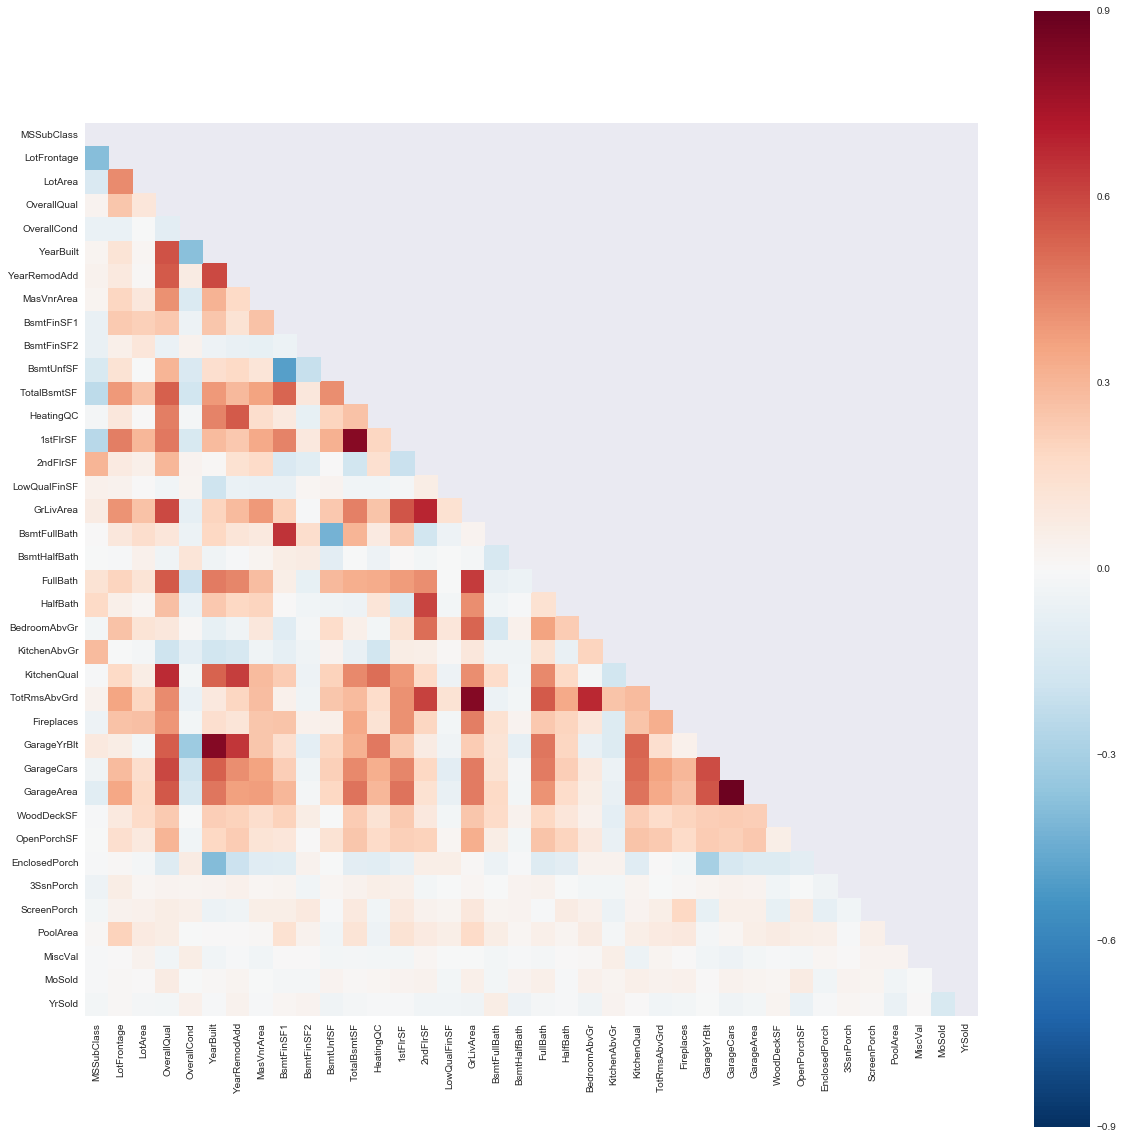

In [10]:
#We can calculate the correlation coefficients among variables and flag those with extremely high values
corr = df_quant[df_quant.columns[1:39]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize=(20,20))
plt.subplot2grid((1,1), (0,0))
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.9, square=True, annot=False)

### Calculation of the skewness and check for high values that could justify a transformation

In [11]:
#We can also calculate the skewness and notice that there are many variables
skew = df_quant[df_quant.columns[1:40]].skew()
print(skew)

MSSubClass        1.407657
LotFrontage       2.163569
LotArea          12.207688
OverallQual       0.216944
OverallCond       0.693067
YearBuilt        -0.613461
YearRemodAdd     -0.503562
MasVnrArea        2.669084
BsmtFinSF1        1.685503
BsmtFinSF2        4.255261
BsmtUnfSF         0.920268
TotalBsmtSF       1.524255
HeatingQC        -0.540458
1stFlrSF          1.376757
2ndFlrSF          0.813030
LowQualFinSF      9.011341
GrLivArea         1.366560
BsmtFullBath      0.596067
BsmtHalfBath      4.103403
FullBath          0.036562
HalfBath          0.675897
BedroomAbvGr      0.211790
KitchenAbvGr      4.488397
KitchenQual       0.386765
TotRmsAbvGrd      0.676341
Fireplaces        0.649565
GarageYrBlt      -0.649415
GarageCars       -0.342549
GarageArea        0.179981
WoodDeckSF        1.541376
OpenPorchSF       2.364342
EnclosedPorch     3.089872
3SsnPorch        10.304342
ScreenPorch       4.122214
PoolArea         14.828374
MiscVal          24.476794
MoSold            0.212053
Y

In [12]:
df_quant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 40 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
MasVnrArea       1452 non-null float64
BsmtFinSF1       1460 non-null int64
BsmtFinSF2       1460 non-null int64
BsmtUnfSF        1460 non-null int64
TotalBsmtSF      1460 non-null int64
HeatingQC        1460 non-null int64
1stFlrSF         1460 non-null int64
2ndFlrSF         1460 non-null int64
LowQualFinSF     1460 non-null int64
GrLivArea        1460 non-null int64
BsmtFullBath     1460 non-null int64
BsmtHalfBath     1460 non-null int64
FullBath         1460 non-null int64
HalfBath         1460 non-null int64
BedroomAbvGr     1460 non-null int64
KitchenAbvGr     1460 non-null int64
K

In [23]:
#Function to eliminate columns with more than N null values and substitute null values in the remaining with median:
def null_value_treatment(dataframe, thresh_null):
    for col in dataframe.columns.values:
        if np.sum(dataframe[col].isnull()) > thresh_null:
            dataframe.drop(col, axis=1, inplace=True)
        elif np.sum(dataframe[col].isnull()) > 0:
            median = dataframe[col].median()
            idx = np.where(dataframe[col].isnull())[0]
            dataframe[col].iloc[idx] = median
    return

null_value_treatment(df_quant, 150)
null_value_treatment(df_quant_test, 150)

In [24]:
df_quant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 39 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null float64
LotArea          1460 non-null float64
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
MasVnrArea       1460 non-null float64
BsmtFinSF1       1460 non-null float64
BsmtFinSF2       1460 non-null float64
BsmtUnfSF        1460 non-null int64
TotalBsmtSF      1460 non-null float64
HeatingQC        1460 non-null int64
1stFlrSF         1460 non-null float64
2ndFlrSF         1460 non-null int64
LowQualFinSF     1460 non-null float64
GrLivArea        1460 non-null float64
BsmtFullBath     1460 non-null int64
BsmtHalfBath     1460 non-null float64
FullBath         1460 non-null int64
HalfBath         1460 non-null int64
BedroomAbvGr     1460 non-null int64
KitchenAbvGr     1460 non-null float64
KitchenQual      146

In [25]:
def transform_skew(dataframe, skew_thresh):
    for col in dataframe.columns.values: 
        if (dataframe[col].skew()) > skew_thresh:
            dataframe[col] = np.log(dataframe[col])
            dataframe[col] = dataframe[col].apply(lambda x: 0 if x == (-1*np.inf) else x)
#           df_quant[col] = Normalizer().fit_transform(df_quant[col].reshape(1,-1))[0]

transform_skew(df_quant, 1.0)
transform_skew(df_quant_test, 1.0)

In [28]:
def null_value_treatment_categorical(dataframe, thresh_null):
    for col in dataframe.columns.values:
        if np.sum(dataframe[col].isnull()) > thresh_null:
            dataframe.drop(col, axis=1, inplace=True)
        elif np.sum(dataframe[col].isnull()) > 0:
            dataframe[col] = dataframe[col].fillna('MIA', inplace=True)
    return

null_value_treatment_categorical(df_category, 150)
null_value_treatment_categorical(df_category_test, 150)

In [ ]:
#We can do it as separate loops instead...
'''#Remove columns with too many null values(more then 10% of null data points), transform those with skewness larger than 1. 
#Courtesy of BradenFitz-Gerald

for col in df_quant.columns.values: 
    if np.sum(df_quant[col].isnull()) > 150:
        df_quant = df_quant.drop(col, axis = 1)
    elif np.sum(df_quant[col].isnull()) > 0:
        median = df_quant[col].median()
        idx = np.where(df_quant[col].isnull())[0]
        df_quant[col].iloc[idx] = median
#        outliers = np.where(is_outlier(df_quant[col]))
#        df_quant[col].iloc[outliers] = median
#Which columns for the training set have the conditions above?
#we can do the same loop, eliminating columns with more than xxx of null values
#Let's substitute values... in principle with the median of the test set, but could be alo the median of the training set
for col in df_quant_test.columns.values: 
    if np.sum(df_quant_test[col].isnull()) > 150:
        df_quant_test = df_quant_test.drop(col, axis = 1)    
    elif np.sum(df_quant_test[col].isnull()) > 0:
        median = df_quant_test[col].median()
        idx = np.where(df_quant_test[col].isnull())[0]
        df_quant_test[col].iloc[idx] = median'''
        
'''for col in df_quant.columns.values: 
    if (df_quant[col].skew()) > 1.0:
        df_quant[col] = np.log(df_quant[col])
        df_quant[col] = df_quant[col].apply(lambda x: 0 if x == (-1*np.inf) else x)
#        df_quant[col] = Normalizer().fit_transform(df_quant[col].reshape(1,-1))[0]
#run the same edits for the test set 
for col in df_quant_test.columns.values: 
    if (df_quant_test[col].skew()) > 1.0:
        df_quant_test[col] = np.log(df_quant_test[col])
        df_quant_test[col] = df_quant_test[col].apply(lambda x: 0 if x == (-1*np.inf) else x)'''

In [ ]:
#Let's edit the categorical variables
'''for col in df_category.columns.values: 
    if np.sum(df_category[col].isnull()) > 150:
        df_category = df_category.drop(col, axis = 1)
    elif np.sum(df_category[col].isnull()) > 0:
        df_category[col] = df_category[col].fillna('MIA')'''

In [ ]:
'''#Which columns for the training set have the conditions above?
#we can do the same loop, eliminating columns with more than xxx of null values
for col in df_category_test.columns.values: 
    if np.sum(df_category_test[col].isnull()) > 150:
        df_category_test = df_category_test.drop(col, axis = 1)
    elif np.sum(df_category_test[col].isnull()) > 0:
        df_category_test[col] = df_category_test[col].fillna('MIA')'''

In [29]:
cat_variables = df_category.columns.values
cat_variables_test = df_category_test.columns.values

df_dummies = pd.get_dummies(df_category, columns=cat_variables)
df_dummies_test = pd.get_dummies(df_category_test, columns=cat_variables)

In [30]:
y_train = df_quant['SalePrice']

X_train = df_dummies.join(df_quant)
X_train = X_train.drop(['SalePrice', 'Id'], axis=1)

X_test = df_dummies_test.join(df_quant_test)
X_test = X_test.drop(['Id'], axis=1)

In [31]:
X_train.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,548,0.000000,4.110874,0.000000,0.0,0.0,0.0,0.0,2,2008
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,460,5.697093,0.000000,0.000000,0.0,0.0,0.0,0.0,5,2007
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,608,0.000000,3.737670,0.000000,0.0,0.0,0.0,0.0,9,2008
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,642,0.000000,3.555348,1.723802,0.0,0.0,0.0,0.0,2,2006
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,836,5.257495,4.430817,0.000000,0.0,0.0,0.0,0.0,12,2008


In [32]:
X_test.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_MIA,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,730.0,4.941642,0.000000,0.0,0.0,1.566007,0.0,0.000000,6,2010
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,312.0,5.973810,3.583519,0.0,0.0,0.000000,0.0,2.244265,6,2010
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,482.0,5.356586,3.526361,0.0,0.0,0.000000,0.0,0.000000,3,2010
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,470.0,5.886104,3.583519,0.0,0.0,0.000000,0.0,0.000000,6,2010
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,506.0,0.000000,4.406719,0.0,0.0,1.603382,0.0,0.000000,1,2010


In [33]:
y_train.head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

### A Random Forest to start
#### Ideally, we would fit a linear model with two intentions: (1) Eliminate redundant (collinear) variables (2) assess the importance of each variables. This way, we would have a reference point (and a score) to compare with when doing our Random Forests. 
#### However, I will skip this step and head straight into the random forest model...

In [143]:
# Train a random forest with XXX decision trees
model_rf1 = RandomForestRegressor(n_estimators=500)

In [144]:
#Fit the training data
model_rf1.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

#### Let's check the score...

In [155]:
# Define folds for cross-validation
kf = cv.KFold(1460, n_folds=5, shuffle=True)
#kf = 6
scores = cv.cross_val_score(model_rf1, X_train, y_train, cv=kf)
print(scores, 'and the mean score is =', scores.mean())

[ 0.87141257  0.84763377  0.88642751  0.89191312  0.8498041 ] and the mean score is = 0.869438214887


#### Let's investigate the feature importance, possibly eliminating redundant variables, if any

TypeError: unsupported operand type(s) for %: 'Text' and 'int'

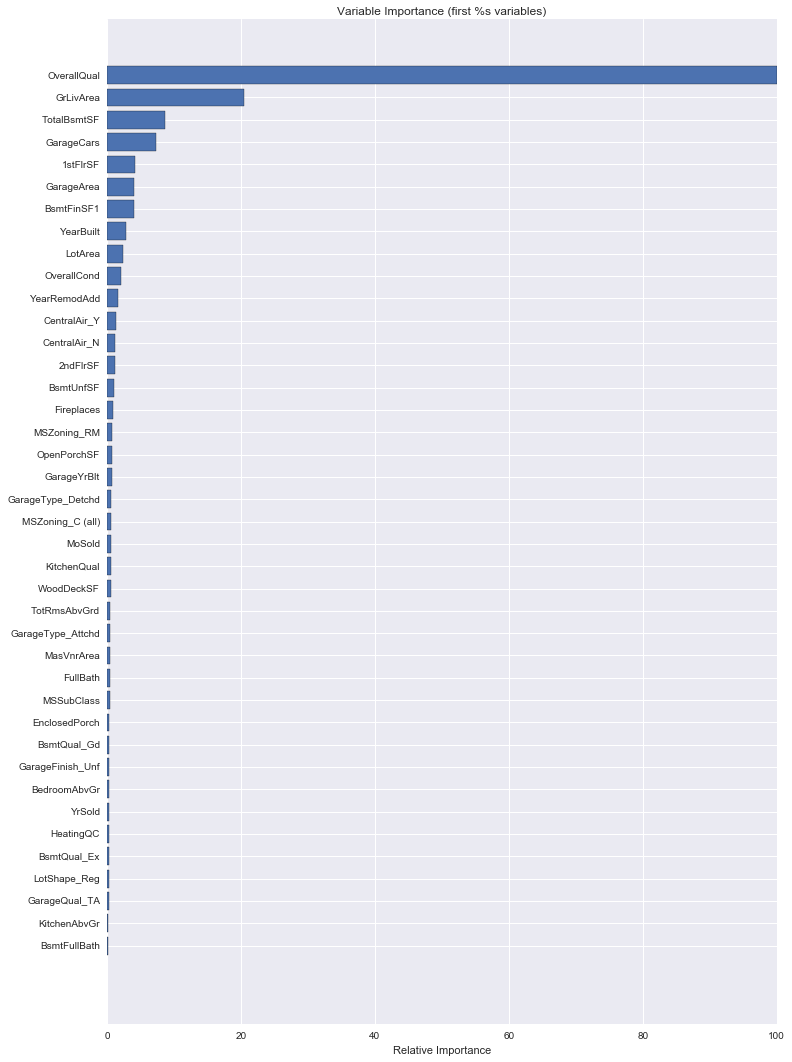

In [156]:
# Investigate importances of predictors
###model_rf1.feature_importances_
feature_importance = model_rf1.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
featimp = feature_importance[sorted_idx]
feat = X_train.columns[sorted_idx]
pos = np.arange(sorted_idx.shape[0]) + .5
a = 233 #To limit the number of features
b = 273 - a

plt.figure(figsize=(12, 18))
plt.subplot(1, 1, 1)
plt.barh(pos[a:273], featimp[a:273], align='center')
plt.yticks(pos[a:273], feat[a:273])
plt.xlabel('Relative Importance')
plt.title('Variable Importance (first %s variables)') % b
plt.show()

In [110]:
#Let's check for a second the names of the columns to be sure what we have...
X_train.columns.values

array(['MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'LotShape_IR1',
       'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk',
       'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl',
       'Utilities_AllPub', 'Utilities_NoSeWa', 'LotConfig_Corner',
       'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3',
       'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod',
       'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Ne

In [ ]:
# compute test set deviance
'''test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')'''

#### Assess the scores for a few different regressors based on decision trees

In [ ]:
'''# Investigate importances of predictors
rf1.feature_importances_

# Define folds for cross-validation
kf = cv.KFold(n=10, shuffle=True)

# Cross validation score
mses = cv.cross_val_score(rf1, X, y, scoring='mean_squared_error', cv=kf)
np.mean(-mses)

# Determine ‘optimal’ number of components
gs = grid_search.GridSearchCV(
    estimator=spls,
    param_grid={
        'pls__n_components': np.arange(1, 10)
    },
    scoring='mean_squared_error',
    cv=kf
)
gs.fit(boroughs, feelings)

-gs.best_score_
gs.best_estimator_
gs.grid_scores_
xxxxxxxxxxxxxxxxxxx

confusion_matrix(y_train, model_lr1.predict(X_train))'''
'''
def check_classifiers(X, y):
    """
    Returns a sorted list of accuracy scores from fitting and scoring passed data
    against several algorithms.
    """
    _cv = kf
    classifier_score = {}
    
    scores = cross_val_score(sklearn.ensemble.RandomForestRegressor(), X, y, cv=_cv)
    classifier_score['Random Forest Regressor'] = scores.mean()
    
    scores = cross_val_score(sklearn.ensemble.RandomForestRegressor(), X, y, cv=_cv)
    classifier_score['XXXXKNeighborsClassifier'] = scores.mean()
    
    scores = cross_val_score(sklearn.ensemble.RandomForestRegressor(), X, y, cv=_cv)
    classifier_score['XXXXRandomForestClassifier'] = scores.mean()
    
    scores = cross_val_score(sklearn.ensemble.RandomForestRegressor(), X, y, cv=_cv)
    classifier_score['XXXXSVC'] = scores.mean()
    
    scores = cross_val_score(sklearn.ensemble.RandomForestRegressor(), X, y, cv=_cv)
    classifier_score['XXXXXXGaussianNB'] = scores.mean()

    #return sorted(classifier_score.items(), key=operator.itemgetter(1), reverse=True)
    return sorted(classifier_score.items(), reverse=True)
'''

#### Select a regressor and perform grid search for selection of best parameters

#### Evaluate the chosen model

#### Output the predictions